In [30]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import lambertw
import tensorflow as tf
from tensorflow.python.framework import ops
from scipy.stats import norm

In [31]:
ops.reset_default_graph()
sess = tf.InteractiveSession()
npr.seed(100)

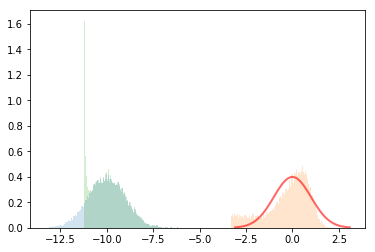

In [32]:
z = np.random.normal(0.0, 1.0, size= 10000)

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
plt.plot(x, norm.pdf(x), 'r-', lw=2, alpha=0.6, label='norm pdf')

# offset the histogam by -10 for clarity
plt.hist(z - 10, 100, normed=True, alpha=0.2)

lam = 0.3
# skew the data with W_\lambda(z) as forward transformation
y = (lambertw(lam * z, 0).real)/lam
# unskew the data with $ye^(\lambda y)$ as inverse transformation
z_1 = y * np.exp(lam * y)

plt.hist(y, 100, normed=True, alpha=0.2)
plt.hist(z_1 - 10, 100, normed=True, alpha=0.2)
plt.show()

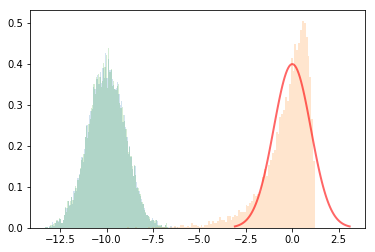

In [33]:

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
plt.plot(x, norm.pdf(x), 'r-', lw=2, alpha=0.6, label='norm pdf')

# offset the histogam by -10 for clarity
plt.hist(z - 10, 100, normed=True, alpha=0.2)

lam = -0.3
# skew the data with W_\lambda(z) as forward transformation
y = z * np.exp(lam * z)
# unskew the data with $ye^(\lambda y)$ as inverse transformation
z_1 = lambertw(lam * y, 0).real/lam

plt.hist(y, 100, normed=True, alpha=0.2)
plt.hist(z_1 - 10, 100, normed=True, alpha=0.2)

plt.show()

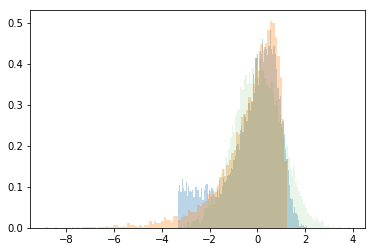

In [45]:
lam = 0.3
y_1 = (lambertw(lam * z, 0).real)/lam
lam = -0.3
y_2 = z * np.exp(lam * z)

plt.hist(y_1, 100, normed=True, alpha=0.3)
plt.hist(y_2, 100, normed=True, alpha=0.3)
# plt.hist(z, 100, normed=True, alpha=0.1)

plt.show()